In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, filtfilt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from adan_pytorch import Adan

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import clear_output

In [2]:
PATH = "/home/gromov_n/MASS/ss2/"

### Loading and preprocess data

In [3]:
def ReadSignals():
    all_data = {}
    for file in tqdm(os.listdir(PATH)):
        if "PSG" in file:
            data = mne.io.read_raw_edf(PATH + file, verbose=False)
            raw_data = data.get_data()

            labels = np.load("data/" + file + "labels.npy")
            assert len(labels) == len(raw_data[0])
            number = int(file[8:10])
            all_data[number] = [raw_data, labels]
           
            data.close()
    return all_data

In [4]:
all_data = ReadSignals()
assert len(all_data) == 19

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [01:35<00:00,  1.01it/s]


Тест и невалидные данные (из статьи)

In [5]:
IDS_INVALID = [4, 8, 15, 16]  # Only 1 expert 
IDS_TEST = [13, 12, 2, 6]

In [6]:
def broad_filter(signal, fs, lowcut=0.1, highcut=35):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [7]:
for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        print(key)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222602.73it/s]

13
12
2
6


In [8]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        test_data.append(broad_filter(values[0], 256))
        test_labels.append(values[1])
    elif key not in IDS_INVALID:
        train_data.append(broad_filter(values[0], 256))
        train_labels.append(values[1])
assert len(train_data) == 11
assert len(test_data) == 4     

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:12<00:00,  3.80s/it]


In [9]:
signal = train_data[0]
means = signal.mean(axis = 1)[..., None]
stds = signal.std(axis = 1)[..., None]

norm_signal = (signal - means) / stds

In [10]:
np.quantile(norm_signal, q=[0.25, 0.99])

array([-0.37411323,  2.77274967])

In [11]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [12]:
NormalizeAndClip(train_data)
NormalizeAndClip(test_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.85s/it]


In [13]:
#np.save("data/all_train", train_data)
#np.save("data/all_test", test_data)

In [14]:
#train_cpy = np.load("data/all_train.npy")

In [15]:
for i in range(len(train_data)):
    train_data[i] = torch.FloatTensor(train_data[i])#.to("cuda")
    new_trainl = torch.zeros(2, len(train_labels[i]))
    new_trainl = (torch.arange(2) == torch.LongTensor(train_labels[i])[:,None]).T
    new_trainl = new_trainl.float()
    train_labels[i] = new_trainl#.to("cuda")

for i in range(len(test_data)):
    test_data[i] = torch.FloatTensor(test_data[i])#.to("cuda")
    new_testl = torch.zeros(2, len(test_labels[i]))
    new_testl = (torch.arange(2) == torch.LongTensor(test_labels[i])[:,None]).T
    new_testl = new_testl.float()
    test_labels[i] = new_testl#.to("cuda")

In [16]:
s = 0
lens = 0
for i in range(len(train_data)):
    s += train_labels[i][1].sum()
    lens += len(train_labels[i][1])
print(s / lens)

s = 0
lens = 0
for i in range(len(test_data)):
    s += test_labels[i][1].sum()
    lens += len(test_labels[i][1])

print(s / lens)

tensor(0.0625)
tensor(0.0556)


In [17]:
RECEPTIVE_FIELD = 4000
OVERLAP = 0 # now is 0 should test 520

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD, ov = OVERLAP):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(ov, L- rf - ov, rf)):
        train_seq = x[:, i-ov:i+rf+ov]
        train_label = labels[:, i:i+rf]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [18]:
train_samples = []
for i in range(len(train_data)):
    train_samples += CreateSamples(train_data[i], train_labels[i])

test_samples = []
for i in range(len(test_data)):
    test_samples += CreateSamples(test_data[i], test_labels[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:00<00:00, 125675.33it/s]


In [19]:
print("number of train samples", len(train_samples))
print("number of test samples", len(test_samples))


number of train samples 20406
number of test samples 8440


In [20]:
for i in range(len(train_samples)):
    maxim = train_samples[i][1][1].max()
    if maxim == 1:
        print(i)
        break

27


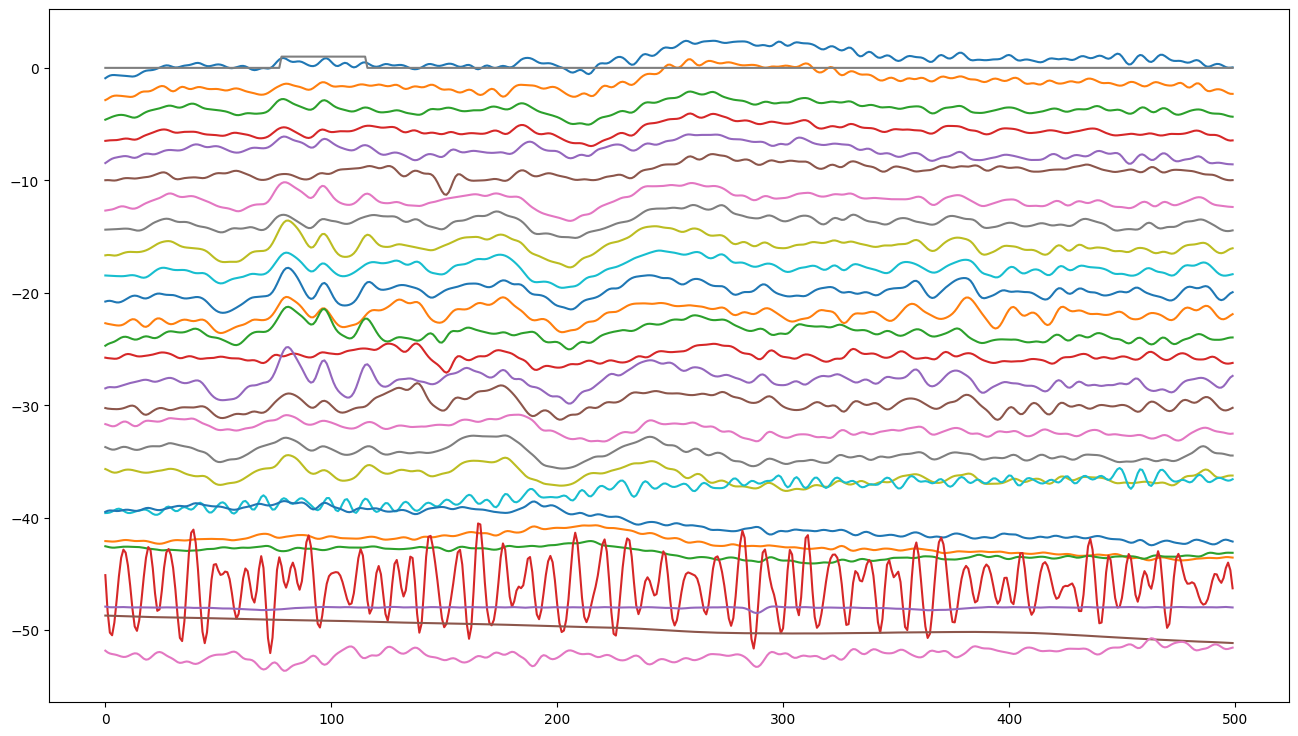

In [21]:
plt.figure(figsize=(16, 9))
for i in range(27):
    plt.plot(train_samples[27][0][i][3000:3500].cpu() - 2 * i)

plt.plot(train_samples[27][1][1][3000:3500].cpu())

In [19]:
train_dataloader = DataLoader(train_samples, batch_size=120, shuffle=True, drop_last=True) 
test_dataloader = DataLoader(test_samples, batch_size=120, shuffle=False, drop_last=True)

### Network

In [20]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=12)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest') #for 4000 it is 5 and for 100 is 4
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        #print("x", x.size())
        pool_x1 = self.AvgPool1D1(x)
        #print("pool_x1", pool_x1.size())
        
        pool_x2 = self.AvgPool1D2(x)
        #print("pool_x2", pool_x2.size())
        
        pool_x3 = self.AvgPool1D3(x)
        #print("pool_x3", pool_x3.size())
        
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        #print("out_0", out_0.size())
        out_1 = self.layer2(out_0)        
        #print("out_1", out_1.size())
        
        
        x = torch.cat([out_1,pool_x1],1)

        #print("x", x.size())
        out_2 = self.layer3(x)
        #print("out_2", out_2.size())
        
        x = torch.cat([out_2,pool_x2],1)
        #print("x", x.size())
        x = self.layer4(x)
        #print("x", x.size())
        
        
        #############Decoder####################
        
        up = self.upsample1(x)
        #print("up", up.size())
        
        up = torch.cat([up,out_2],1)
        #print("up", up.size())
        
        up = self.cbr_up1(up)
        #print("up", up.size())
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_1],1)
        #print("up", up.size())
        
        up = self.cbr_up2(up)
        #print("up", up.size())
        
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_0],1)
        #print("up", up.size())
        
        up = self.cbr_up3(up)
        #print("up", up.size())
        
        out = self.outcov(up)
        #print("out", out.size())
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [46]:
#test_input100 = torch.FloatTensor(np.ones((32, 27, 4000)))

In [21]:
model = UNET_1D(27,128,7,3) #(input_dim, hidden_layer, kernel_size, depth)
model = model.to("cuda")

In [48]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()
      
        #print("x", x.shape)
        

        out = model(x.to("cuda"))
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out, y.to("cuda"))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

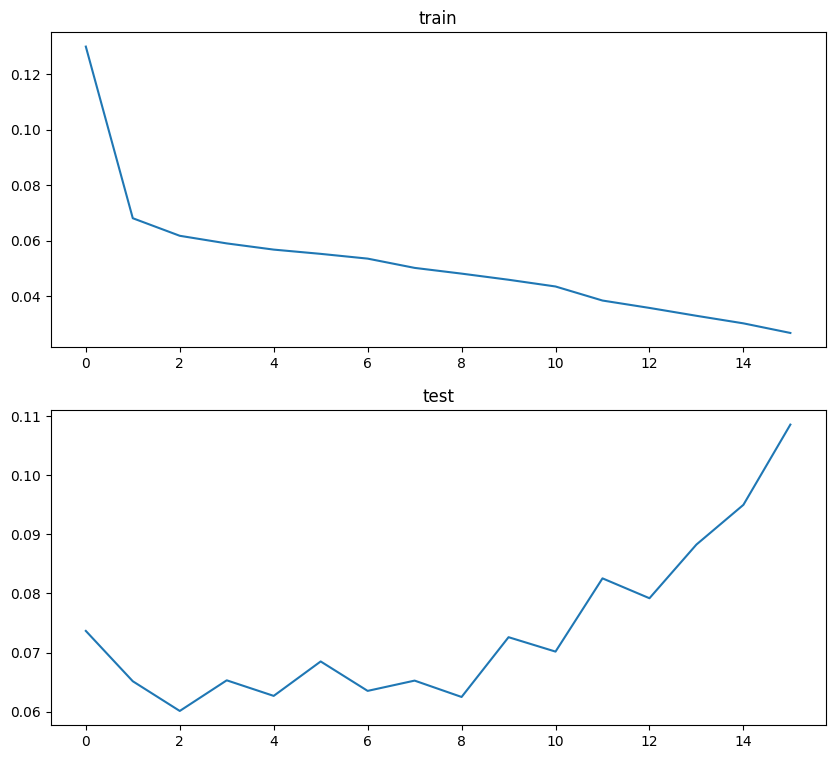

Epoch[16/1000] | loss train:0.026775, test:0.108583


21it [00:03,  5.73it/s]


KeyboardInterrupt: 

In [49]:
# define optimizer and loss function

criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
optimizer = Adan(
    model.parameters(),
    lr = 1e-3,                  # learning rate (can be much higher than Adam, up to 5-10x)
    betas = (0.02, 0.08, 0.01), # beta 1-2-3 as described in paper - author says most sensitive to beta3 tuning
    weight_decay = 0.02         # weight decay 0.02 is optimal per author
)

#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.0001)
epochs = 1000

losses_train = []
losses_test = []
best_loss = 10e9
# begin training

early_stop_count = 30
current_es = 0
for epoch in range(epochs): 
    
        
    loss_train = run_epoch(model, optimizer, criterion, train_dataloader, is_training=True)
    loss_val = run_epoch(model, optimizer, criterion, test_dataloader)
    scheduler.step(loss_val)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        current_es = 0
        best_loss = losses_test[-1]
        torch.save(model.state_dict(), "./models/4000UnetADANNoEarlyStop")
    else:
        current_es += 1
    #if current_es == early_stop_count:
        #break

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()


    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

### Collecting predicts

In [32]:
#torch.save(model.state_dict(), "./models/4000SEED2_520OverlapADANNoEarlyStop226Epochs")

In [22]:
model.load_state_dict(torch.load("./models/4000UnetADANNoEarlyStop"))

<All keys matched successfully>

In [23]:
def CollectingPreds(model):

    model.eval()
    model.cpu()
    all_preds = []
    for i in range(len(test_labels)):
        record_preds = []
        for idx in tqdm(range(OVERLAP, test_data[i].size()[1]- RECEPTIVE_FIELD - OVERLAP, RECEPTIVE_FIELD)):

            train_seq = test_data[i][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...]
            train_label = test_labels[i][:, idx:idx+RECEPTIVE_FIELD]
            #x = x.float()
            #print("x", x.shape)

        
            out = model(train_seq)
            m = nn.Softmax(dim=1)
            out = m(out)
            #print(out.size())
            #print("first", out[:, 0].max())
            #print("second", out[:, 1].max())
            
            preds = np.argmax(out.detach().cpu().numpy(), axis=1)
            record_preds.append(preds)
        shapes = np.array(record_preds).shape
        record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
        all_preds.append(record_preds)
    return all_preds

In [24]:
all_preds = CollectingPreds(model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1855/1855 [02:18<00:00, 13.39it/s]


In [25]:
# for i in range(len(all_preds)):
#     np.save("predicts/preds4000UNetADAN" + str(i), all_preds[i]) 

In [50]:
all_preds = []
for i in range(4):
    all_preds.append(np.load("predicts/preds4000UNetADAN" + str(i) + ".npy"))

### Results

#### Raw labels

In [26]:
def GetRawMetricsAndCM(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])
        lens.append(pred_len)
        sums.append((predictions[i] == test_labels[i][1, :pred_len].numpy()).sum())      

        acc.append(sums[i] / lens[i])
        precision.append(precision_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        recall.append(recall_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        f1.append(f1_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        

        cm = confusion_matrix(test_labels[i][1, :pred_len].numpy(), predictions[i])
        all_cm += cm
        print("=============Record " + str(i) + "================")
        print("accuracy", acc[i])
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    print("Full accuracy", np.sum(sums)/np.sum(lens))
    print("Mean accuracy", np.mean(acc))
    print("Mean precision", np.mean(precision))
    print("Mean recall", np.mean(recall))
    print("Mean f1", np.mean(f1))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()
    

##### Unet

=============Record 0================
accuracy 0.9707581650193382
precision 0.760092026429298
recall 0.7809464026709724
f1 score 0.7703781067749438
=============Record 1================
accuracy 0.9752530986613783
precision 0.7636540516839768
recall 0.7107386795484572
f1 score 0.7362468097248569
=============Record 2================
accuracy 0.9775362561356538
precision 0.8983794950218627
recall 0.801963103969944
f1 score 0.847437697318028
=============Record 3================
accuracy 0.9844524258760108
precision 0.858321538857437
recall 0.5219802522508424
f1 score 0.649172371218042
===========ALL RECORDS SCORE==================
Full accuracy 0.976641913507109
Mean accuracy 0.9769999864230954
Mean precision 0.8201117779981436
Mean recall 0.703907109610054
Mean f1 0.7508087462589677
Full Confusion Matrix


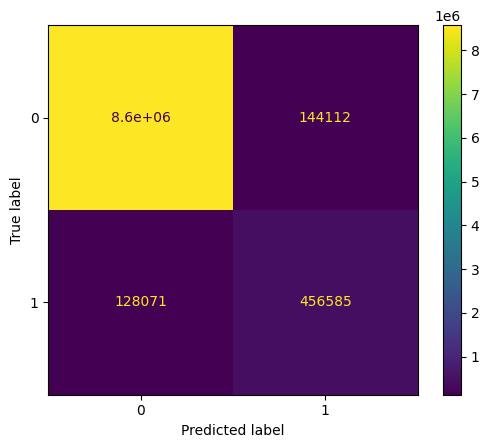

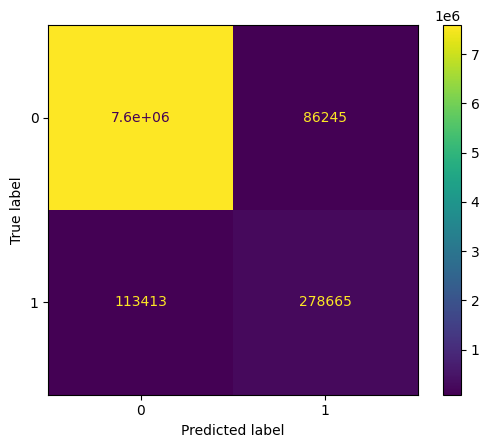

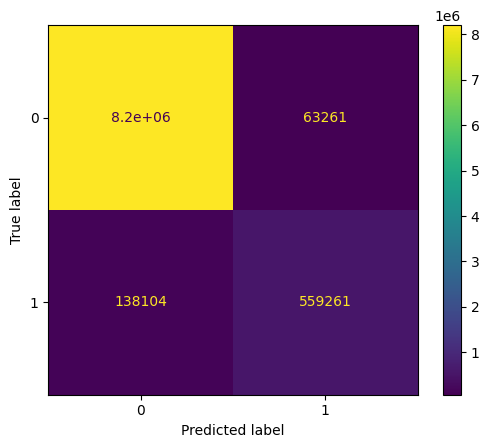

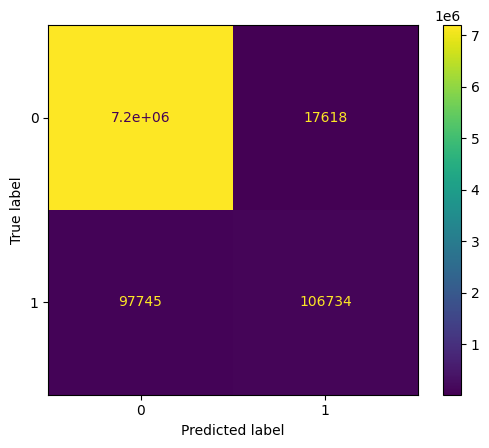

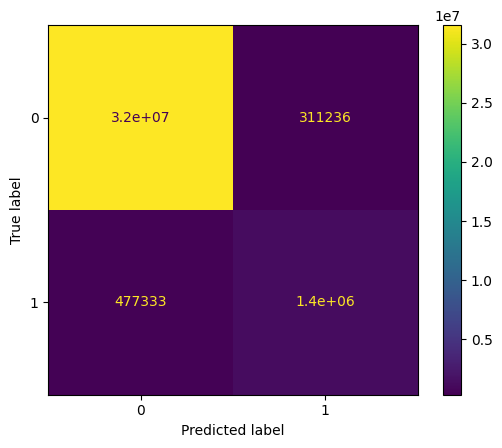

In [27]:
GetRawMetricsAndCM(all_preds, test_labels)

##### Zero overlap

=============Record 0================
accuracy 0.968536312849162
precision 0.7586478321916351
recall 0.7319380969322131
f1 score 0.7450536593519093
=============Record 1================
accuracy 0.9737064947942489
precision 0.7928362192422862
recall 0.6212819898081504
f1 score 0.6966530248041664
=============Record 2================
accuracy 0.9720063587684069
precision 0.866397139930665
recall 0.7568819771568691
f1 score 0.8079453168230672
=============Record 3================
accuracy 0.9821300539083558
precision 0.8265554586422446
recall 0.444906322898684
f1 score 0.5784519127750419
===========ALL RECORDS SCORE==================
Full accuracy 0.9736809834123222
Mean accuracy 0.9740948050800433
Mean precision 0.8111091625017077
Mean recall 0.6387520966989791
Mean f1 0.7070259784385463
Full Confusion Matrix


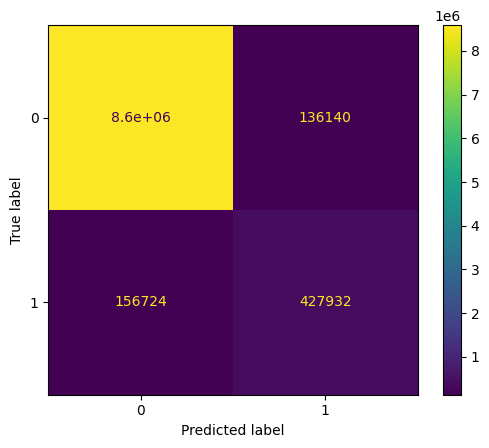

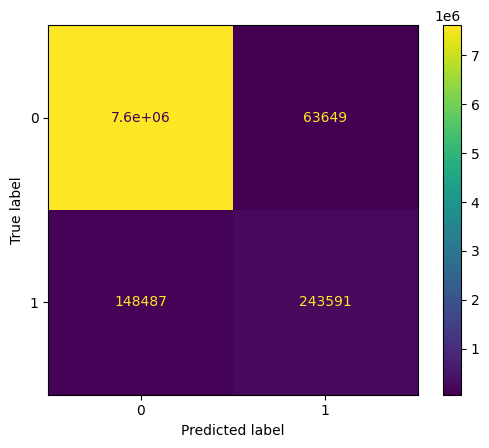

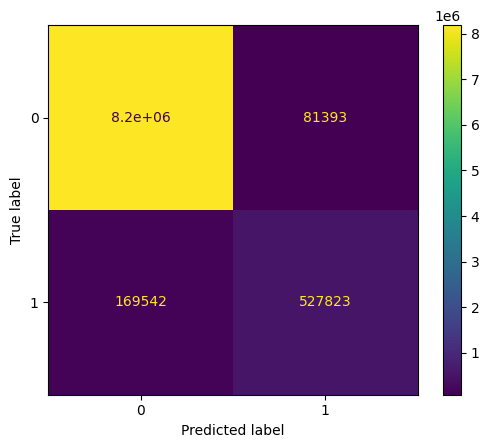

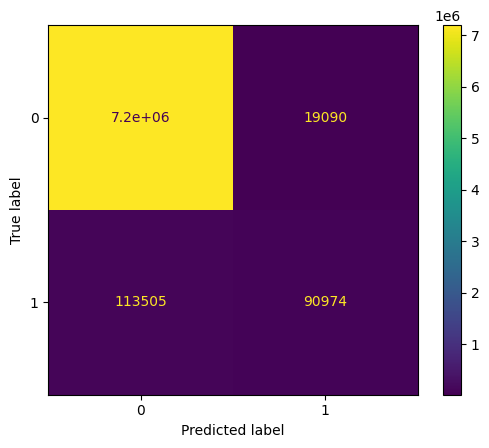

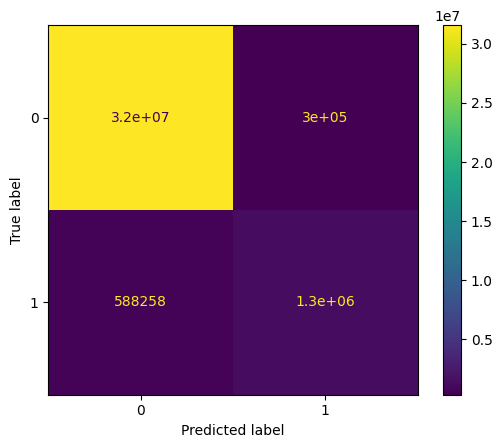

In [71]:
GetRawMetricsAndCM(all_preds, test_labels)

##### Zero overlap no early stop

=============Record 0================
accuracy 0.9710135367425871
precision 0.7717822910336446
recall 0.764622273610465
f1 score 0.7681855986142997
=============Record 1================
accuracy 0.9742183936539415
precision 0.7984073872331595
recall 0.6280587026050939
f1 score 0.7030615187394184
=============Record 2================
accuracy 0.973580655957162
precision 0.8766586189298473
recall 0.7685315437396485
f1 score 0.8190418554966429
=============Record 3================
accuracy 0.9817297843665769
precision 0.8184801094350784
recall 0.43306647626406625
f1 score 0.5664292499144468
===========ALL RECORDS SCORE==================
Full accuracy 0.9748163507109004
Mean accuracy 0.9751355926800669
Mean precision 0.8163321016579325
Mean recall 0.6485697490548185
Mean f1 0.714179555691202
Full Confusion Matrix


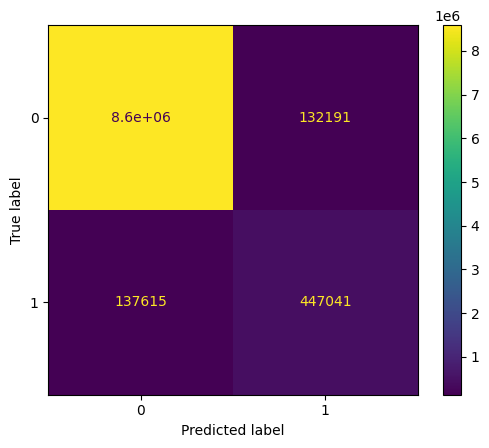

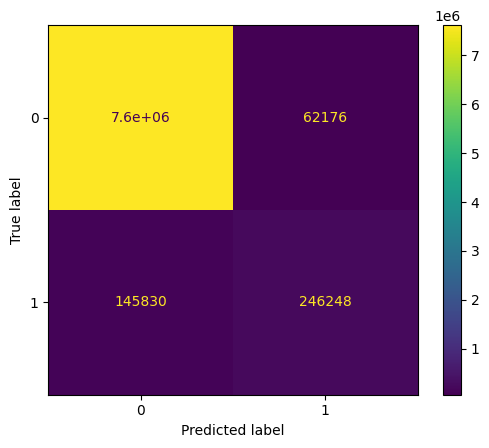

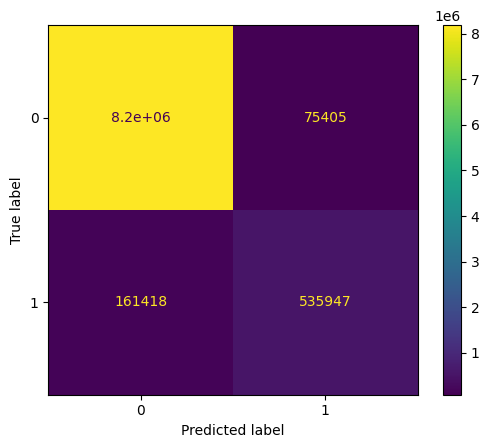

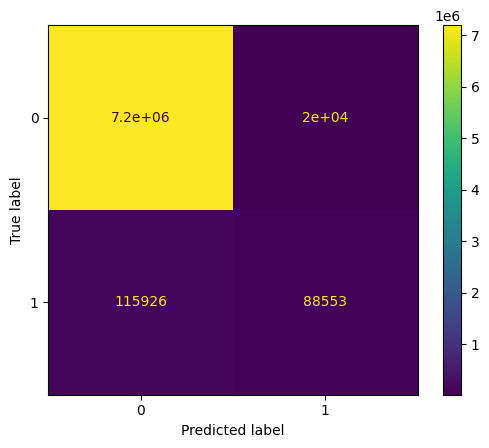

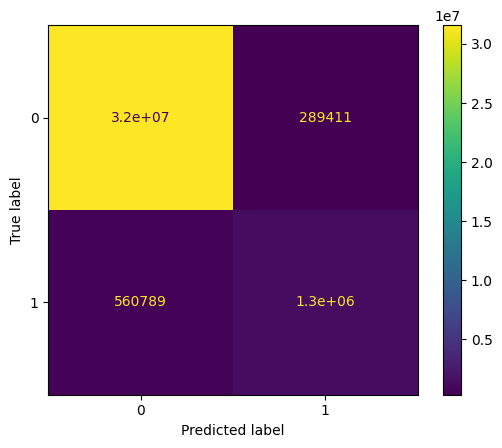

In [51]:
GetRawMetricsAndCM(all_preds, test_labels)

##### 520 overlap

In [36]:
test_labels_overlap = [labels[:, OVERLAP:] for labels in test_labels]

=============Record 0================
accuracy 0.9717739578856898
precision 0.7625120684706312
recall 0.7996975999562136
f1 score 0.7806622675785424
=============Record 1================
accuracy 0.9754258800198314
precision 0.8211904067455057
recall 0.6319227296609348
f1 score 0.7142305308522752
=============Record 2================
accuracy 0.97570703125
precision 0.8983689875099654
recall 0.7756196539832082
f1 score 0.8324938723839793
=============Record 3================
accuracy 0.9824467654986523
precision 0.8583275409329626
recall 0.4348074863433409
f1 score 0.5772131025147453
===========ALL RECORDS SCORE==================
Full accuracy 0.9760367934589407
Mean accuracy 0.9763384086635434
Mean precision 0.8350997509147662
Mean recall 0.6605118674859244
Mean f1 0.7261499433323855
Full Confusion Matrix


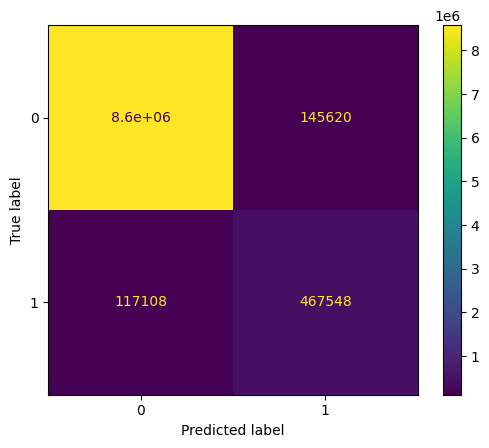

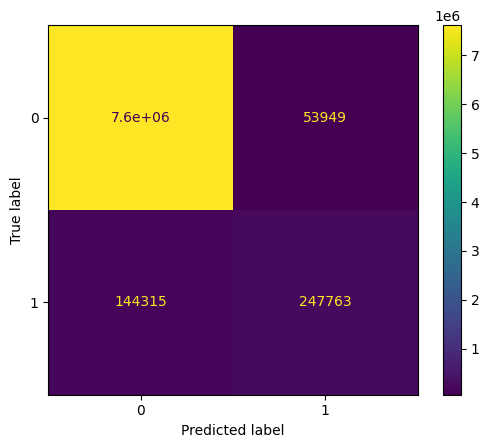

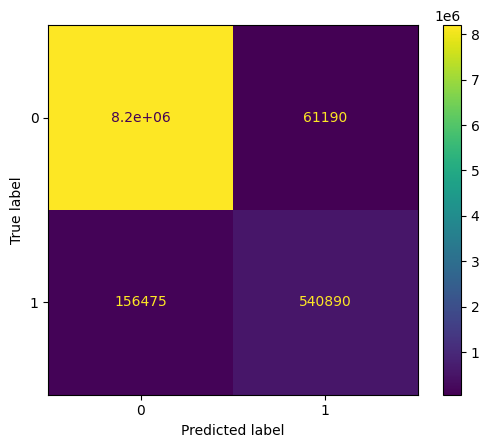

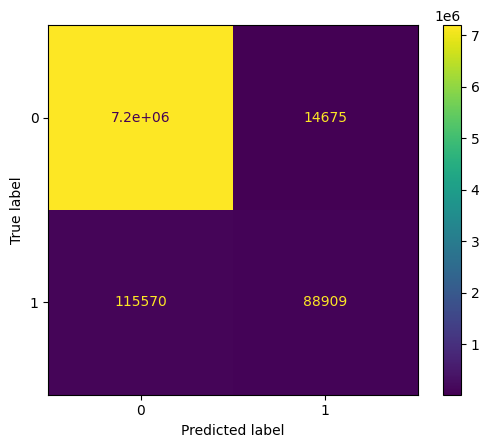

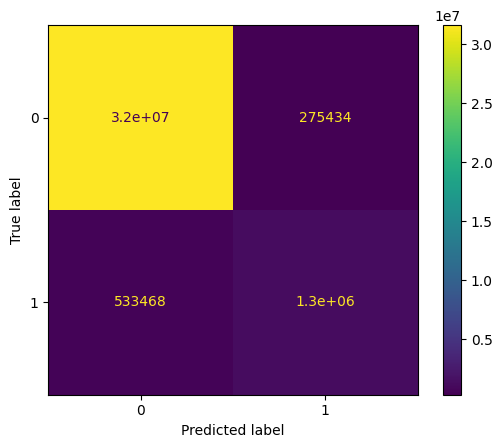

In [37]:
GetRawMetricsAndCM(all_preds, test_labels_overlap)

#### EpiSpike

In [30]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    while i < len(pred_labels):
        while true_labels[i] == 1:
            is_true_flag = 1
            if pred_labels[i] == 1:
                is_pred_flag = 1
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN              

In [31]:
def GetRawMetricsAndCMEPI(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            

        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        print("=============Record " + str(i) + "================")
    
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    
    
    print("Full precision", TP_sum / (TP_sum + FP_sum))
    print("Full recall", TP_sum / (TP_sum + FN_sum))
    print("Full f1", 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()

##### Unet

=============Record 0================
precision 0.6755424063116371
recall 0.9351535836177475
f1 score 0.7844259948468365
=============Record 1================
precision 0.6961690885072656
recall 0.8459069020866774
f1 score 0.763768115942029
=============Record 2================
precision 0.8866253321523472
recall 0.9001798561151079
f1 score 0.893351182507809
=============Record 3================
precision 0.85
recall 0.6221959858323495
f1 score 0.7184730743012951
===========ALL RECORDS SCORE==================
Full precision 0.7714953271028038
Full recall 0.8566240055344172
Full f1 0.811834125553188
Full Confusion Matrix


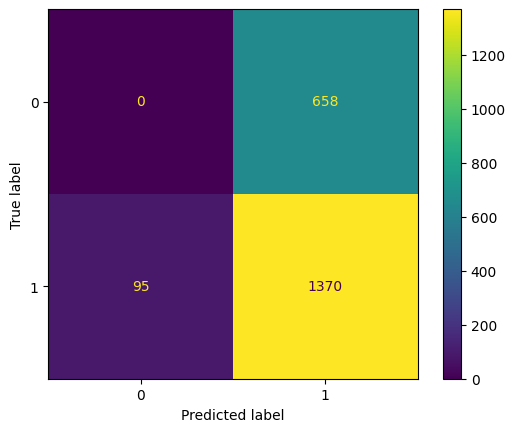

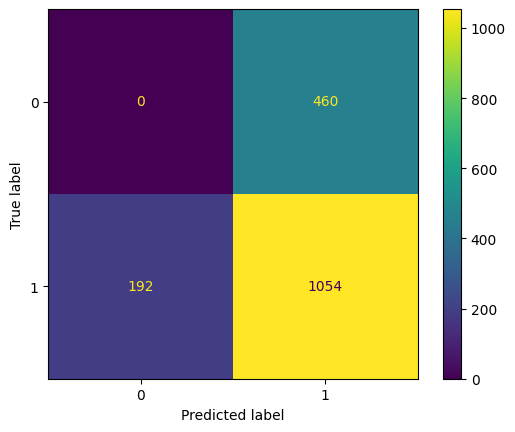

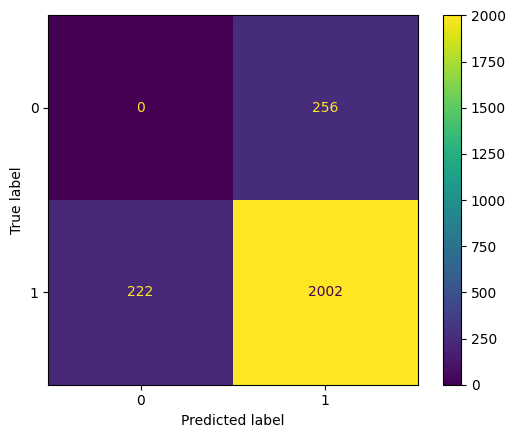

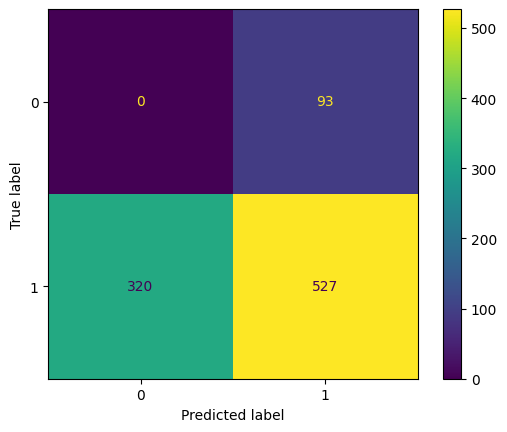

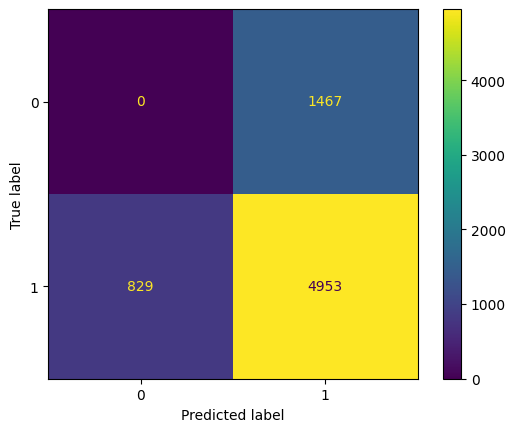

In [32]:
GetRawMetricsAndCMEPI(all_preds, test_labels)


In [33]:
precs = [0.6755424063116371, 0.6961690885072656, 0.8866253321523472, 0.85]
recall = [0.9351535836177475, 0.8459069020866774, 0.9001798561151079, 0.6221959858323495]
f1 = [0.7844259948468365, 0.763768115942029, 0.893351182507809, 0.7184730743012951]

In [34]:
print(np.mean(precs))
print(np.std(precs))

print(np.mean(recall))
print(np.std(recall))

print(np.mean(f1))
print(np.std(f1))

0.7770842067428124
0.09243100758970108
0.8258590819129705
0.12180869979168375
0.7900045918994925
0.06425875274234369


##### Zero overlap

=============Record 0================
precision 0.7721911855990068
recall 0.8491467576791809
f1 score 0.8088426527958388
=============Record 1================
precision 0.8126110124333925
recall 0.7343499197431782
f1 score 0.7715008431703204
=============Record 2================
precision 0.9147557328015952
recall 0.825089928057554
f1 score 0.8676122931442081
=============Record 3================
precision 0.8739837398373984
recall 0.5076741440377804
f1 score 0.6422703510082151
===========ALL RECORDS SCORE==================
Full precision 0.8450811843361986
Full recall 0.7651331719128329
Mean f1 0.8031224471271671
Full Confusion Matrix


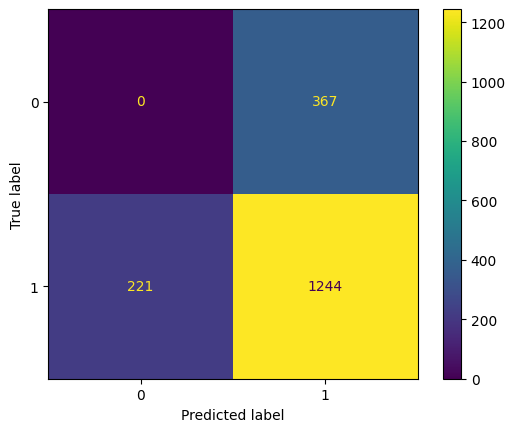

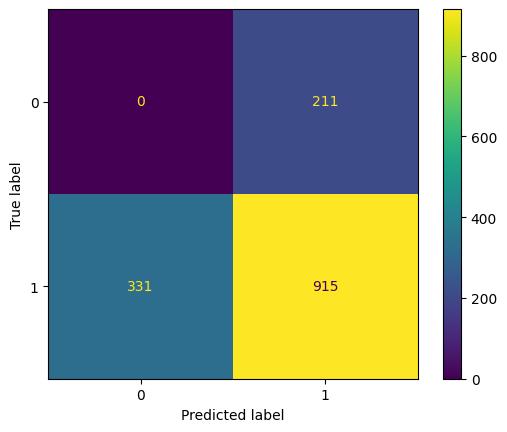

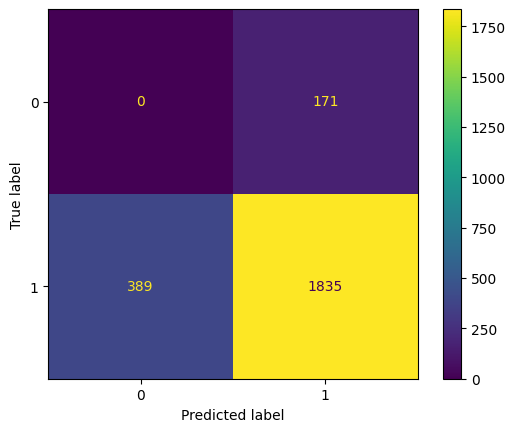

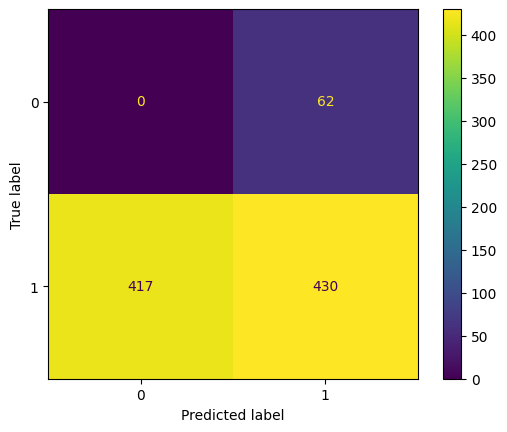

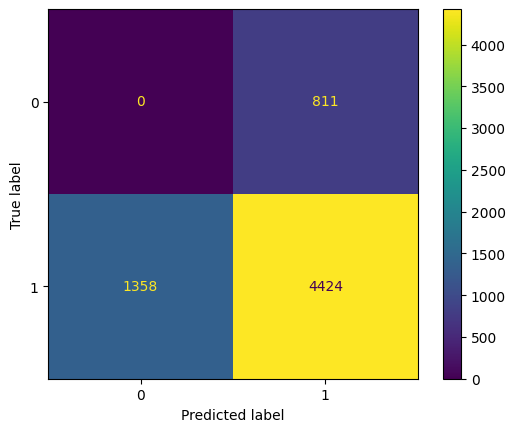

In [69]:
GetRawMetricsAndCMEPI(all_preds, test_labels)

##### Zero overlap no early stop

=============Record 0================
precision 0.8097653772986684
recall 0.8716723549488055
f1 score 0.8395792241946088
=============Record 1================
precision 0.8131768953068592
recall 0.7231139646869984
f1 score 0.7655055225148684
=============Record 2================
precision 0.9303507880020335
recall 0.822841726618705
f1 score 0.8732999284180386
=============Record 3================
precision 0.8736383442265795
recall 0.4734356552538371
f1 score 0.6140888208269525
===========ALL RECORDS SCORE==================
Full precision 0.8626491880258267
Full recall 0.762538913870633
Full f1 0.8095106949417057
Full Confusion Matrix


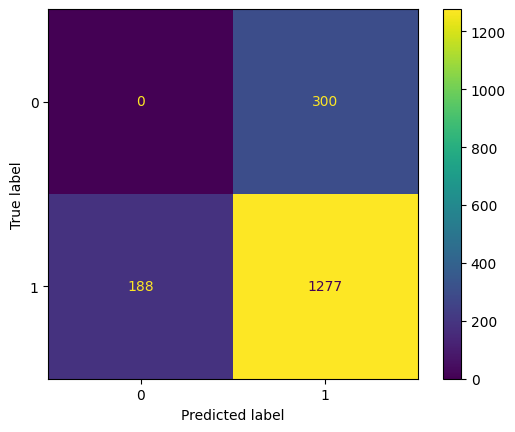

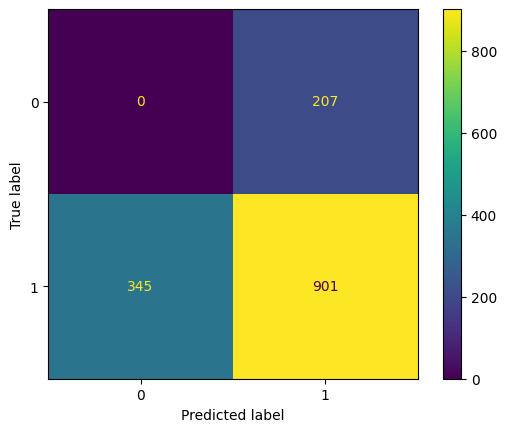

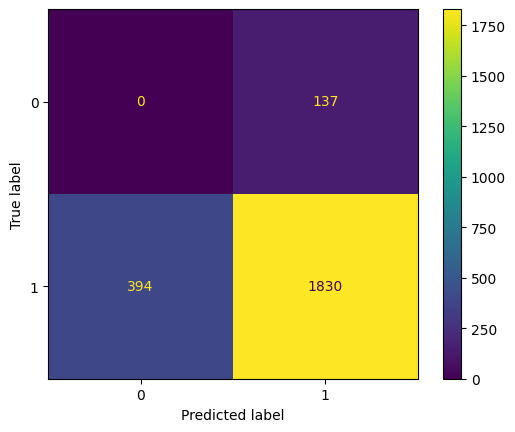

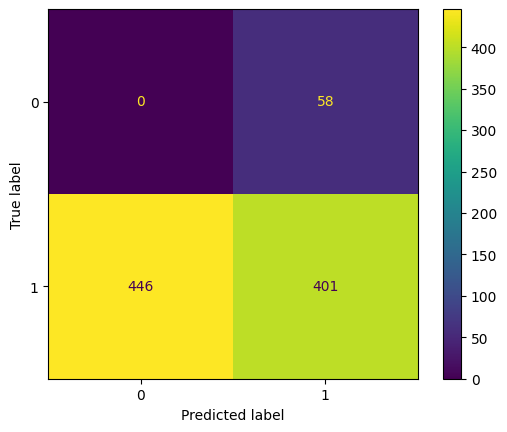

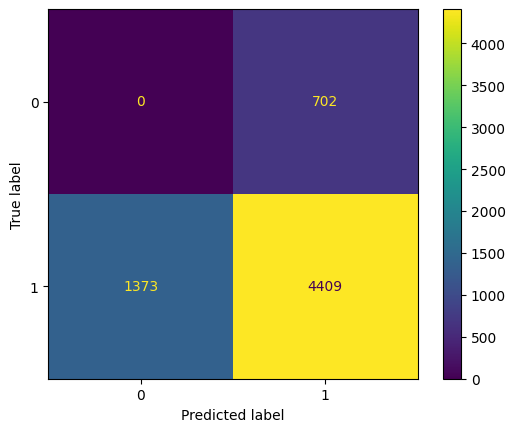

In [52]:
GetRawMetricsAndCMEPI(all_preds, test_labels)

##### 520 overlap

=============Record 0================
precision 0.7996422182468694
recall 0.9153583617747441
f1 score 0.8535964353914705
=============Record 1================
precision 0.8387698042870456
recall 0.7223113964686998
f1 score 0.7761966364812419
=============Record 2================
precision 0.9493606138107417
recall 0.8345323741007195
f1 score 0.8882507776980139
=============Record 3================
precision 0.9010989010989011
recall 0.48406139315230223
f1 score 0.6298003072196621
===========ALL RECORDS SCORE==================
Full precision 0.8734496124031008
Full recall 0.7794880664130058
Full f1 0.8237982087369767
Full Confusion Matrix


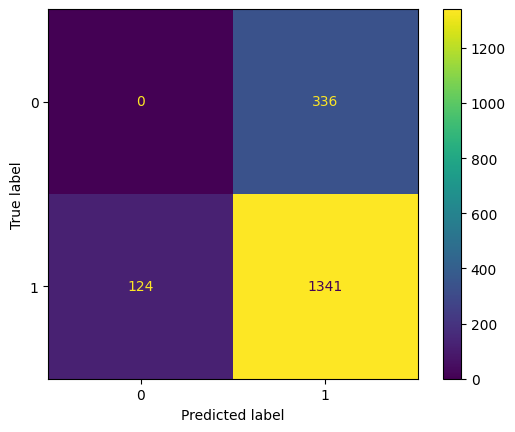

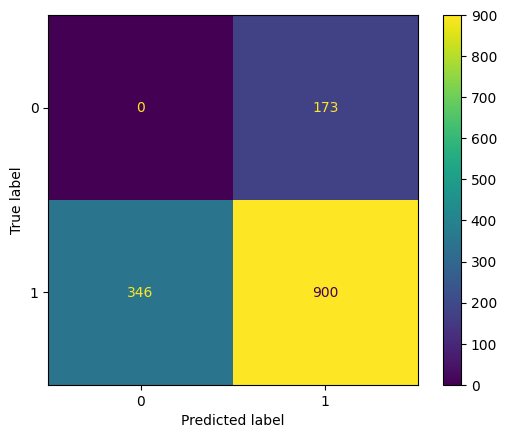

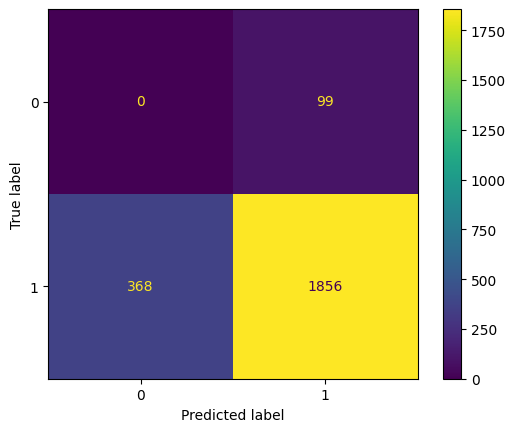

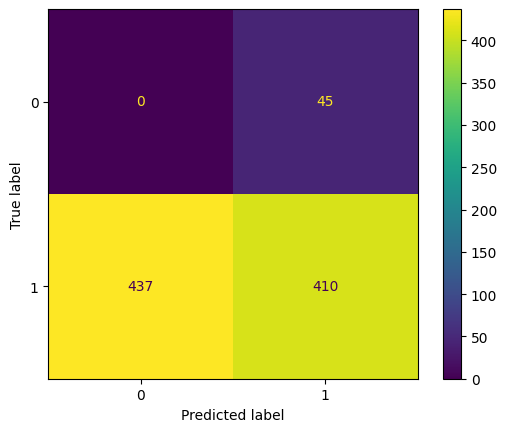

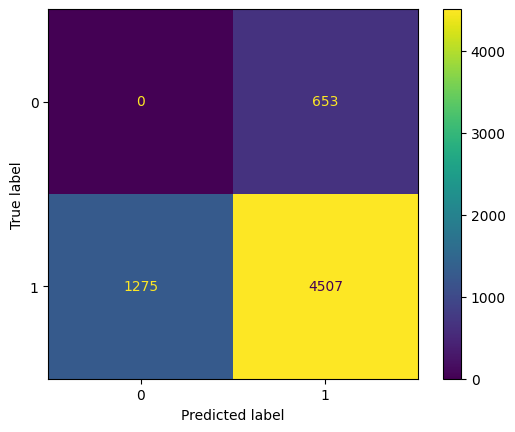

In [41]:
GetRawMetricsAndCMEPI(all_preds, test_labels_overlap)

### EDF wtire

In [29]:
def CreateNewAnnotation(time_start, labels, freq): 
    freq = 1/freq
    i = 0
    label_starts = [time_start]
    label_lens = [-1]
    desc = ["StartPredictionTime"]
    while i < len(labels):
        if labels[i] == 1:
            desc.append("ModelPrediction")
            label_starts.append(time_start + i*freq)
            cur_start = i
            while labels[i] == 1:
                i += 1
            label_lens.append((i - cur_start) * freq)
        i += 1
    label_starts += [time_start + i*freq]
    label_lens += [-1]
    desc += ["EndPredictionTime"]

    return np.array(label_starts), np.array(label_lens), np.array(desc)

In [34]:
IDS_TEST

[2, 6, 12, 13]

In [50]:
def WriteEDF(predictions, test_idx):
    freq = 256
    time_start = 0
    for i, idx in enumerate(test_idx):
        preds_annotations = CreateNewAnnotation(time_start, predictions[i], freq)
        suffics = str(idx)
        if idx < 10:
            suffics = "0" + str(idx)
        data = mne.io.read_raw_edf("data/01-02-00" + suffics + " PSG.edfWithLabels.edf")

        preds_annotations = list(preds_annotations)
        preds_annotations[1] = np.clip(preds_annotations[1], a_min=0, a_max = None)

        old_annot = np.array([[data.annotations[i]["onset"], data.annotations[i]["duration"], data.annotations[i]["description"]] 
                      for i in range(len(data.annotations))])
        full_annot = np.concatenate([np.array(preds_annotations), old_annot.T], axis=1)
        annotations = mne.Annotations(full_annot[0], full_annot[1], full_annot[2])
        data.set_annotations(annotations)
        
        data.export("predicts/01-02-00" + suffics + " PSG.edfWithLabelsSEED4000.edf", overwrite=True)
        data.close()
        

In [51]:
WriteEDF(all_preds, IDS_TEST)

Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0013 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 9311231  =      0.000 ... 36371.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0012 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 8071679  =      0.000 ... 31529.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0002 PSG.edfWithLabels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 8964095  =      0.000 ... 35015.996 secs...
Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/data/01-02-0006 PSG.e